# Portfolio Constructions Using Centralities


In [1]:
import numpy as np
import pandas as pd

#%matplotlib inline
import matplotlib.pyplot as plt

from itertools import product

from time import time

#import timeit
#import seaborn as sns
#import networkx as nx
#from PMFG_mod import PMFG

## Importing Data

In [2]:
# S&P constituents daily return data

log_returns_df = pd.read_excel("data/historical_2016_2019.xlsx", index_col='Names Date')
stock_names = log_returns_df.columns   # this is just simple returns, not log -- but whatevs
df_shape = (log_returns_df.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset.")
print(f"Data timeperiod covers: {log_returns_df.index[0]} to {log_returns_df.index[-1]}")

ticker_names = log_returns_df.columns

There are 1006 rows and 485 columns in the dataset.
Data timeperiod covers: 2016-01-04 00:00:00 to 2019-12-31 00:00:00


In [3]:
log_returns_df.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Names Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,-0.026788,-0.034002,0.011494,0.000855,-0.027515,-0.017742,-0.055826,-0.044088,-0.025550,-0.020971,...,-0.005848,-0.024910,-0.006286,-0.032703,-0.011507,-0.011499,-0.007603,-0.045370,-0.021612,-0.013564
2016-01-05,-0.003441,-0.009533,-0.006831,-0.025059,-0.004166,0.014626,-0.002816,-0.000233,0.005205,0.004023,...,0.010084,0.014847,0.008521,0.020387,-0.000277,-0.002493,0.020823,-0.025117,-0.010857,0.015655
2016-01-06,0.004439,0.017522,-0.026455,-0.019570,0.000174,-0.015286,0.003529,-0.008388,-0.001954,-0.014295,...,0.010538,-0.018287,-0.008321,-0.014486,-0.012476,-0.007080,0.004330,-0.039957,-0.029145,0.000208
2016-01-07,-0.042475,-0.018918,0.011073,-0.042205,-0.002963,-0.031932,-0.039625,-0.023966,-0.029366,-0.020984,...,0.003842,-0.039448,-0.016006,-0.008785,-0.025828,-0.034116,-0.022993,-0.045316,-0.030020,-0.030404
2016-01-08,-0.010513,-0.001978,-0.021971,0.005288,-0.027268,-0.005785,0.032471,-0.020944,-0.009681,-0.014140,...,-0.010935,-0.020534,-0.020202,-0.028635,-0.009510,-0.013607,-0.004217,-0.002693,-0.011254,-0.014605


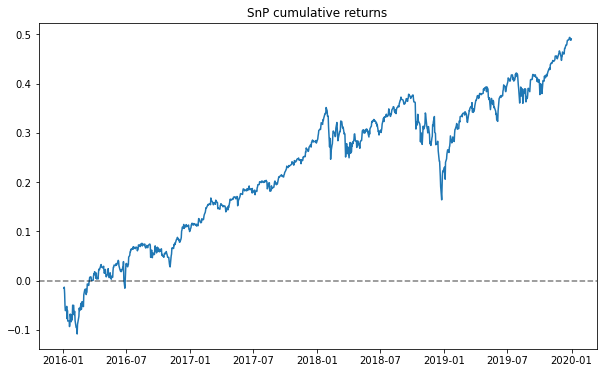

In [4]:
# S&P500 daily returns
SnP_returns = pd.read_csv('data/SnP_returns.csv', index_col='DATE', parse_dates=True).squeeze()

plt.figure(figsize=(10,6))
plt.title('SnP cumulative returns')
plt.plot(SnP_returns.cumsum())
plt.axhline(0, linestyle='--', color='k', alpha=.5)
plt.show()

In [5]:
# XY centrality ranking; computed in the previous workbook
XY_rankings = pd.read_csv("data/XY_rankings.csv", index_col='Date', parse_dates=True)
#XY_rankings = pd.read_csv("data/XY_rankings_126.csv", index_col='Date', parse_dates=True)
print(XY_rankings.info())

# quarterly rebalanced XY ranking
XY_rankings.iloc[252:505:63]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1006 entries, 2016-01-04 to 2019-12-31
Columns: 485 entries, A to ZTS
dtypes: float64(485)
memory usage: 3.7 MB
None


,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,470.0,448.0,47.0,117.5,162.0,176.5,116.0,398.0,82.0,461.0,...,341.0,249.0,36.5,158.0,442.5,430.0,125.0,175.0,347.5,133.0
2017-04-04,462.0,267.5,318.0,76.5,278.0,125.0,251.0,405.0,387.5,441.5,...,352.0,258.0,78.5,168.0,398.0,367.0,208.5,221.0,402.5,185.5
2017-07-05,445.0,260.0,82.0,56.0,320.0,212.0,215.0,323.0,191.0,409.5,...,470.0,162.0,134.0,124.0,415.0,379.0,168.0,199.5,222.5,66.0
2017-10-03,469.0,199.0,53.0,260.0,388.5,324.0,399.0,444.0,60.0,479.0,...,435.0,276.0,25.0,193.0,208.0,392.0,371.0,238.0,232.5,277.0
2018-01-03,457.0,297.5,135.0,356.0,108.0,294.0,336.0,303.5,118.0,313.0,...,313.0,361.0,67.5,50.0,258.0,340.5,109.0,38.0,359.0,238.0


## "Investing in peripherals"
Pozzi proposed that investing in peripherals is better than investing in centrals in terms of information ratio; that peripherals achieve an IR comparable to that of market; and that centrals consistently underperform any other options. Let's see if that's true.

In [6]:
# Unused
def shrinkage_estimator(corr, shrinkage_coef):
    shrinkage_target=np.eye(corr.shape[1])
    return corr*(1-shrinkage_coef) + shrinkage_target*shrinkage_coef

# Ledoit-Wolfe covariance shrinkage estimator
def LW_cov(df, shrinkage_coef=1e-4):
    cov = df.cov()
    return (1 - shrinkage_coef) * cov + shrinkage_coef * np.diag(np.diag(cov))


def markowitz_min_var(cov):
    u = np.ones(len(cov))
    Cinv = np.linalg.solve(cov, u)
    return Cinv/(u@Cinv)

class Backtester:
    def __init__(self, basket_size, basket_update_frequency, rebalance_frequency, rolling_window, XY_ranking):
        self.basket_size=  basket_size
        assert basket_update_frequency >= rebalance_frequency
        self.basket_update_frequency = basket_update_frequency
        self.rebalance_frequency     = rebalance_frequency
        self.rolling_window          = rolling_window
        self.XY_ranking              = XY_ranking
    
    def backtest_equal_weight(self, data, verbose = False):
        T, n = data.shape
        portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
        df_portfolios   = pd.DataFrame(columns=portfolio_names)
        
        XY = self.XY_ranking.iloc[0]
        high_cen_basket = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
        low_cen_basket  = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
        if verbose:
            print('Initial peripheral basket:\n', low_cen_basket)
            print('Initial Central basket:\n'   , high_cen_basket)
        
        for t in range(self.rolling_window, T-1):
            ind_date = data.index[t]
            if (t - self.rolling_window)%self.basket_update_frequency == 0:
                XY = self.XY_ranking.loc[ind_date]
                
                #low_cen_basket  = XY.index[XY <= self.basket_size]
                #high_cen_basket = XY.index[XY>n-self.basket_size+1] #graph completeness issues 
                #high_cen_basket = XY.index[XY > len(XY) - self.basket_size]
                prev_low_cen_basket  = low_cen_basket
                prev_high_cen_basket = high_cen_basket
                high_cen_basket = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
                low_cen_basket  = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
                random_basket   = XY.index[np.random.choice(len(XY), self.basket_size, replace=False)]
                
                if verbose:
                    prev_P, curr_P, prev_C, curr_C = set(prev_low_cen_basket), set(low_cen_basket), set(prev_high_cen_basket), set(high_cen_basket)
                    print('\n--------------------------')
                    print('Recomputing filtered network at ', data.index[t])
                    #print('Peripheral basket: ', low_cen_basket)
                    print('\nStocks that left the peripheral basket: (%d)'%(len(prev_P-curr_P)))
                    print(prev_P-curr_P)
                    print('Stocks that entered the peripheral basket:')
                    print(curr_P-prev_P)
                    
                    #print('Central basket: '   , high_cen_basket)
                    print('\nStocks that entered the central basket: (%d)'%(len(curr_C-prev_C)))
                    print(curr_C-prev_C)
                    print('Stocks that left the central basket: ')
                    print(prev_C-curr_C)
                    
                assert len(low_cen_basket) == len(high_cen_basket) == self.basket_size
                
            #low_cen_returns.append(data[low_cen_basket].iloc[t].sum()/self.basket_size)
            #peripheral_return = data[low_cen_basket].iloc[t]  @ eq_weights
            peripheral_return = data[low_cen_basket].iloc[t+1].mean()
            central_return    = data[high_cen_basket].iloc[t+1].mean() 
            random_return     = data[random_basket].iloc[t+1].mean()
            market_return     = data.iloc[t+1].mean() 
            df_portfolios.loc[data.index[t+1]] = [peripheral_return, central_return, random_return, market_return]
        return df_portfolios
    
        
    def backtest_markowitz_weight(self, data, verbose = False):
        
        T, n = data.shape
        portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
        df_portfolios   = pd.DataFrame(columns=portfolio_names)
        eq_weights      = np.array([1/self.basket_size] * self.basket_size)
        
        XY = self.XY_ranking.iloc[0]
        high_cen_basket = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
        low_cen_basket  = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
        if verbose:
            print('Initial peripheral basket:\n', low_cen_basket)
            print('Initial Central basket:\n'   , high_cen_basket)
        
        for t in range(self.rolling_window, T-1):
            ind_date = data.index[t]
            if (t - self.rolling_window)%self.basket_update_frequency == 0:
                XY = self.XY_ranking.loc[ind_date]
                
                prev_low_cen_basket  = low_cen_basket
                prev_high_cen_basket = high_cen_basket
                high_cen_basket = XY.index[XY.to_numpy().argsort()[:self.basket_size]]
                low_cen_basket  = XY.index[XY.to_numpy().argsort()[-self.basket_size:]]
                random_basket   = XY.index[np.random.choice(len(XY), self.basket_size, replace=False)]
                
                if verbose:
                    prev_P, curr_P, prev_C, curr_C = set(prev_low_cen_basket), set(low_cen_basket), set(prev_high_cen_basket), set(high_cen_basket)
                    print('\n--------------------------')
                    print('Recomputing filtered network at ', data.index[t])
                    print('\nStocks that left the peripheral basket: (%d)'%(len(prev_P-curr_P)))
                    print(prev_P-curr_P)
                    print('Stocks that entered the peripheral basket:')
                    print(curr_P-prev_P)
                    
                    print('\nStocks that entered the central basket: (%d)'%(len(curr_C-prev_C)))
                    print(curr_C-prev_C)
                    print('Stocks that left the central basket: ')
                    print(prev_C-curr_C)
                    
                assert len(low_cen_basket) == len(high_cen_basket) == self.basket_size
                
            # may need to tinker with shrinkage coef (default: 1e-4)
            # can also simplify code with df.rolling() instead of index-slicing the data
            peripheral_return = markowitz_min_var(LW_cov(data.iloc[t - self.rolling_window:t][low_cen_basket]))@data[low_cen_basket].iloc[t+1]
            central_return    = markowitz_min_var(LW_cov(data.iloc[t - self.rolling_window:t][high_cen_basket]))@data[high_cen_basket].iloc[t+1]
            random_return     = markowitz_min_var(LW_cov(data.iloc[t - self.rolling_window:t][random_basket]))@data[random_basket].iloc[t+1]
            market_return     = markowitz_min_var(LW_cov(data.iloc[t - self.rolling_window:t]))@data.iloc[t+1]
            
            df_portfolios.loc[data.index[t+1]] = [peripheral_return, central_return, random_return, market_return]
        return df_portfolios
    
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']

def compute_betas(df, benchmark_returns):
    betas = {}
    ttl_per = pd.DataFrame(columns=['Port returns'])
    for portname in portfolio_names:
        ttl_per['Port returns'] = df[portname]
        ttl_per['SnP returns'] = benchmark_returns
        ttl_per = ttl_per.dropna()
        betas[portname] = ttl_per.cov().iloc[0,1]/ ttl_per.cov().iloc[1,1]
    
    return betas


### Markowitz Min-variance Portfolio

In [7]:
# basket size 30, quarterly rebalance, 1y rolling window for est.
t_back = Backtester(30, 63, 1, 252, XY_rankings)
back_results = t_back.backtest_markowitz_weight(log_returns_df, verbose=True)

Initial peripheral basket:
 Index(['LNC', 'NDAQ', 'MA', 'UAL', 'DHI', 'PFG', 'MGM', 'ALLE', 'MDLZ', 'ADBE',
       'GPN', 'PPG', 'TDY', 'MSCI', 'BAC', 'ITW', 'JPM', 'TMO', 'A', 'APH',
       'C', 'IEX', 'V', 'TEL', 'EFX', 'USD', 'MS', 'IVZ', 'BLK', 'MCO'],
      dtype='object')
Initial Central basket:
 Index(['NEM', 'PENN', 'BH', 'EQIX', 'CMT', 'LEE', 'COG', 'TDG', 'IRM', 'KR',
       'TCX', 'PAR', 'PIR', 'NOV', 'WMB', 'PRGO', 'FMC', 'EXC', 'CMG', 'NRG',
       'CTL', 'ITI', 'CHTR', 'RE', 'EXR', 'SRE', 'CTSH', 'ARE', 'WMT', 'AWK'],
      dtype='object')

--------------------------
Recomputing filtered network at  2017-01-03 00:00:00

Stocks that left the peripheral basket: (0)
set()
Stocks that entered the peripheral basket:
set()

Stocks that entered the central basket: (0)
set()
Stocks that left the central basket: 
set()

--------------------------
Recomputing filtered network at  2017-04-04 00:00:00

Stocks that left the peripheral basket: (14)
{'MA', 'LNC', 'MSCI', 'MDLZ', 'UAL', 

In [8]:
(back_results).head()

,Peripheral,Central,Random,Market
2017-01-04,0.003900,0.001585,0.005071,-0.003655
2017-01-05,0.000568,0.004355,-0.000276,0.006179
2017-01-06,0.007098,0.006296,0.005947,0.004880
2017-01-09,-0.014591,-0.012163,-0.004364,-0.001745
2017-01-10,0.007586,0.005650,-0.001956,-0.003891


### Portfolios: Summary Statistics
(Annualized)

In [9]:
print('Mean returns:')
print(back_results.mean()*252)
print('\nStandard deviation of returns:')
print(back_results.std() * np.sqrt(252))
print('\nRisk Adjusted Returns:')
print(back_results.mean()/back_results.std() * np.sqrt(252))

Mean returns:
Peripheral    0.147690
Central       0.087058
Random        0.128796
Market        0.124782
dtype: float64

Standard deviation of returns:
Peripheral    0.117794
Central       0.101698
Random        0.101406
Market        0.096155
dtype: float64

Risk Adjusted Returns:
Peripheral    1.253796
Central       0.856037
Random        1.270099
Market        1.297715
dtype: float64


In [10]:
XS_returns = back_results.add(-SnP_returns, axis=0).dropna()
XS_returns.head()

,Peripheral,Central,Random,Market
2017-01-04,-0.001822,-0.004137,-0.000651,-0.009377
2017-01-05,0.001339,0.005126,0.000495,0.006950
2017-01-06,0.003581,0.002779,0.002430,0.001363
2017-01-09,-0.011042,-0.008614,-0.000815,0.001804
2017-01-10,0.007586,0.005650,-0.001956,-0.003891


In [11]:
print('Mean excess returns')
print(XS_returns.mean()*252)
print('\nTracking error:')
print(XS_returns.std() * np.sqrt(252))
print('\nInformation ratio:')
print(XS_returns.mean()/back_results.std() * np.sqrt(252))

Mean excess returns
Peripheral    0.019536
Central      -0.041096
Random        0.000642
Market       -0.003372
dtype: float64

Tracking error:
Peripheral    0.115001
Central       0.101359
Random        0.101916
Market        0.128868
dtype: float64

Information ratio:
Peripheral    0.165848
Central      -0.404100
Random        0.006330
Market       -0.035068
dtype: float64


In [12]:
markowitz_betas = compute_betas(back_results, SnP_returns)
markowitz_betas

{'Peripheral': 0.5198370374901607,
 'Central': 0.502103579821265,
 'Random': 0.496836813799768,
 'Market': 0.2754327382530214}

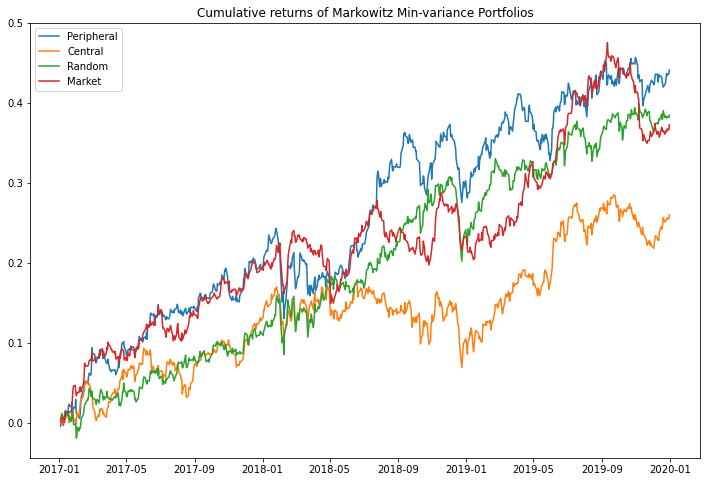

In [54]:
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']

plt.figure(figsize=(12,8))
#plt.title('Cumulative excess returns of Markowitz Min-variance Portfolios')
plt.title('Cumulative returns of Markowitz Min-variance Portfolios')

for name in portfolio_names:
    #plt.plot(XS_returns[name].cumsum(), label=name)
    plt.plot(back_results[name].cumsum(), label=name)

#plt.plot(back_results.cumsum(), label=portfolio_names)
plt.legend()
plt.show();

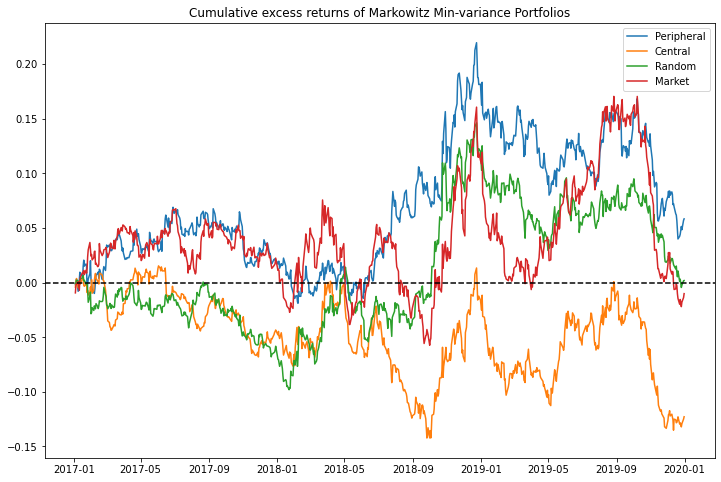

In [55]:
plt.figure(figsize=(12,8))
plt.title('Cumulative excess returns of Markowitz Min-variance Portfolios')
for name in portfolio_names:
    plt.plot(XS_returns[name].cumsum(), label=name)

plt.axhline(0, c='k', linestyle='--')
plt.legend()
#plt.savefig('data/testsavefig.png')
plt.show();

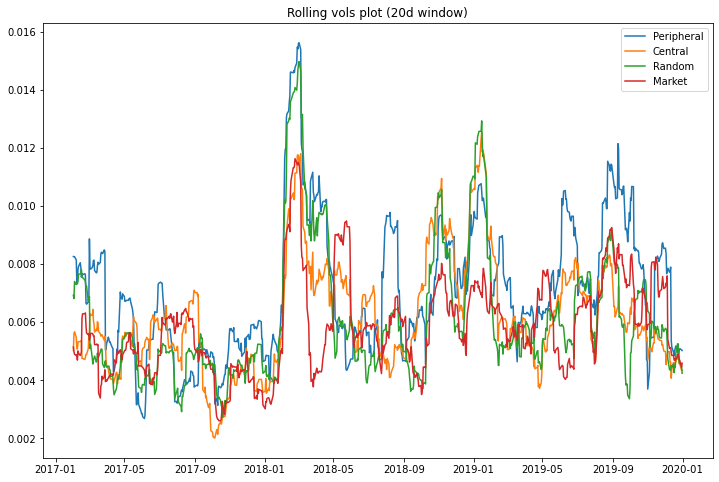

In [60]:
#XS_returns.rolling(10).std()

rwplot = 20 # rolling window for plots

plt.figure(figsize=(12,8))
plt.title('Rolling vols plot for min-var(%dd window)'%rwplot)
for name in portfolio_names:
    #plt.plot(XS_returns[name].rolling(rwplot).mean()/XS_returns[name].rolling(rwplot).std(), label=name)
    #plt.plot(back_results[name].rolling(rwplot).mean()/back_results[name].rolling(rwplot).std(), label=name)
    plt.plot(back_results[name].rolling(rwplot).std(), label=name)
plt.legend()
plt.show();

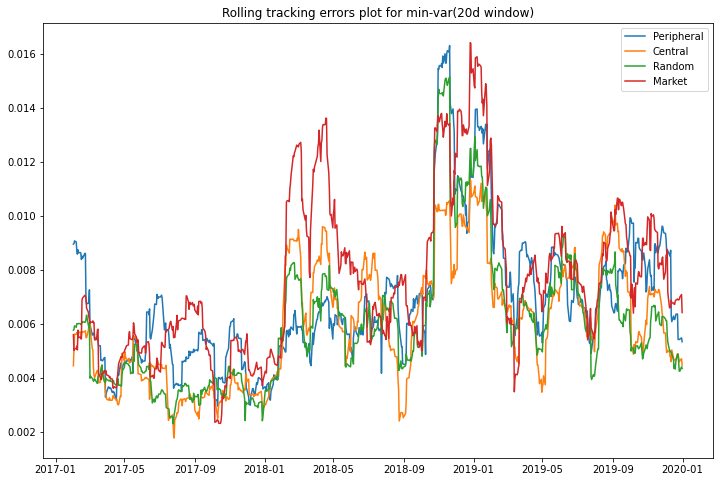

In [66]:
rwplot = 20 # rolling window for plots

plt.figure(figsize=(12,8))
plt.title('Rolling tracking errors plot for min-var(%dd window)'%rwplot)
for name in portfolio_names:
    plt.plot(XS_returns[name].rolling(rwplot).std(), label=name)
plt.legend()
plt.show();

### Equal Weights

In [14]:
eqw_back_results = t_back.backtest_equal_weight(log_returns_df, verbose=False)
eqw_back_results.head()

,Peripheral,Central,Random,Market
2017-01-04,0.011014,0.015581,0.011062,0.011049
2017-01-05,-0.004083,0.006569,-0.001745,-0.002746
2017-01-06,0.006882,0.001804,0.000710,0.003402
2017-01-09,-0.003965,-0.011401,-0.002002,-0.004421
2017-01-10,0.001452,-0.000894,-0.003524,0.002661


In [15]:
print('Mean returns')
print(eqw_back_results.mean()*252)
print('\nStd:')
print(eqw_back_results.std() * np.sqrt(252))
print('\nRisk-adjsuted return:')
print(eqw_back_results.mean()/eqw_back_results.std() * np.sqrt(252))

Mean returns
Peripheral    0.176147
Central       0.143488
Random        0.172654
Market        0.164220
dtype: float64

Std:
Peripheral    0.162701
Central       0.120085
Random        0.131971
Market        0.125923
dtype: float64

Risk-adjsuted return:
Peripheral    1.082641
Central       1.194890
Random        1.308272
Market        1.304126
dtype: float64


In [30]:
eqw_XS_returns = eqw_back_results.add(-SnP_returns, axis=0).dropna()

print('Mean excess returns')
print(eqw_XS_returns.mean()*252)
print('\nTracking error:')
print(eqw_XS_returns.std() * np.sqrt(252))
print('\nInformation ratio:')
print(eqw_XS_returns.mean()/eqw_XS_returns.std() * np.sqrt(252))

Mean excess returns
Peripheral    0.032679
Central       0.016297
Random        0.032702
Market        0.036066
dtype: float64

Tracking error:
Peripheral    0.052379
Central       0.065501
Random        0.040142
Market        0.027837
dtype: float64

Information ratio:
Peripheral    0.623901
Central       0.248806
Random        0.814652
Market        1.295622
dtype: float64


In [31]:
eqw_betas = compute_betas(eqw_back_results, SnP_returns)
eqw_betas

{'Peripheral': 1.1614054100716567,
 'Central': 0.7572855352788183,
 'Random': 0.9697238031147855,
 'Market': 0.9600995382933614}

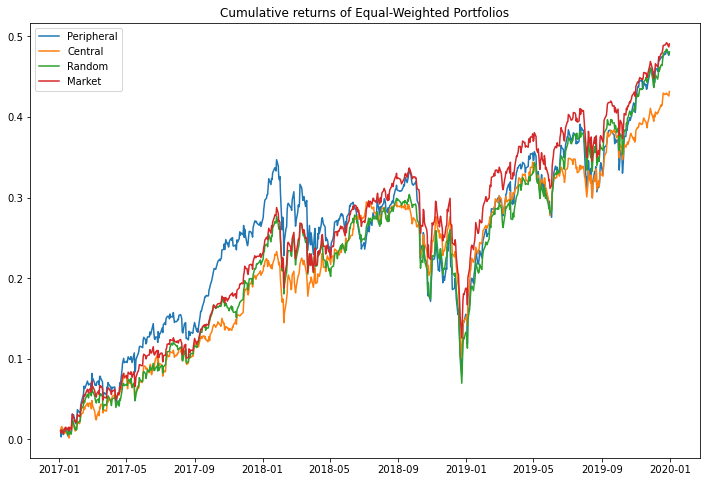

In [62]:
plt.figure(figsize=(12,8))
plt.title('Cumulative returns of Equal-Weighted Portfolios')
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
for name in portfolio_names:
    plt.plot(eqw_back_results[name].cumsum(), label=name)

plt.legend()
plt.show();

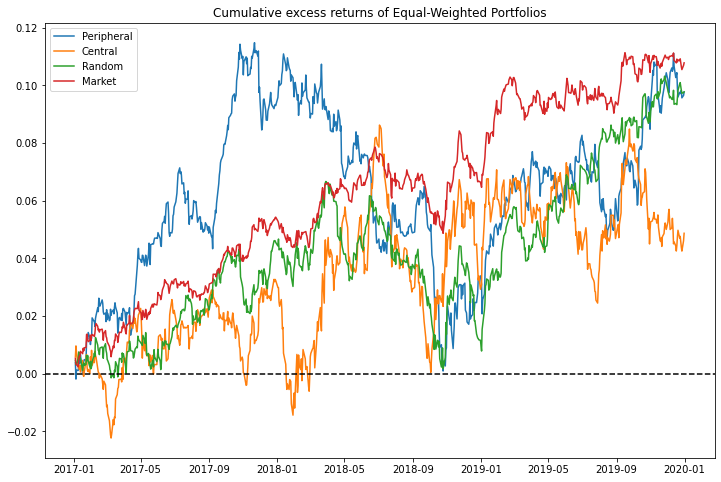

In [63]:
plt.figure(figsize=(12,8))
plt.title('Cumulative excess returns of Equal-Weighted Portfolios')
portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
for name in portfolio_names:
    plt.plot(eqw_XS_returns[name].cumsum(), label=name)

plt.axhline(0, c='k', linestyle='--')
plt.legend()
plt.show();

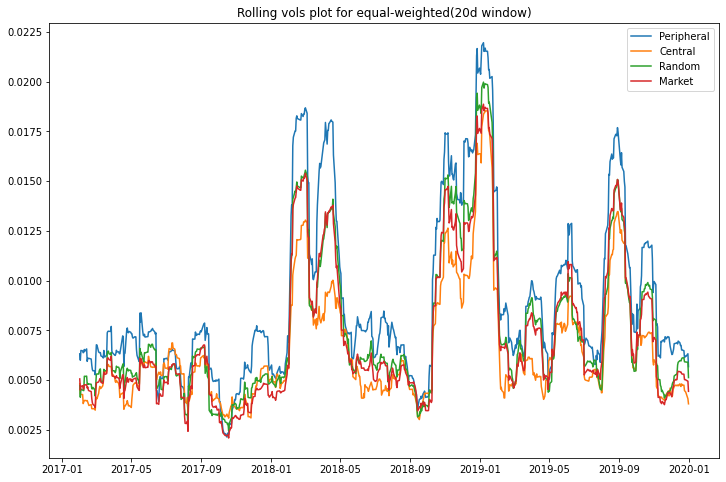

In [67]:
rwplot = 20 # rolling window for plots

plt.figure(figsize=(12,8))
plt.title('Rolling vols plot for equal-weighted(%dd window)'%rwplot)
for name in portfolio_names:
    plt.plot(eqw_back_results[name].rolling(rwplot).std(), label=name)
plt.legend()
plt.show();

### Smaller Basket Size


---------------------------------

Mean returns
Peripheral    0.203392
Central       0.094157
Random        0.125658
Market        0.124782
dtype: float64

Std:
Peripheral    0.136415
Central       0.119041
Random        0.109829
Market        0.096155
dtype: float64

Risk-adjusted return:
Peripheral    1.250092
Central       0.784085
Random        0.952161
Market        0.990938
dtype: float64

Betas:
{'Peripheral': 0.6752097734027426, 'Central': 0.550040704542032, 'Random': 0.5589787608180881, 'Market': 0.2754327382530214}


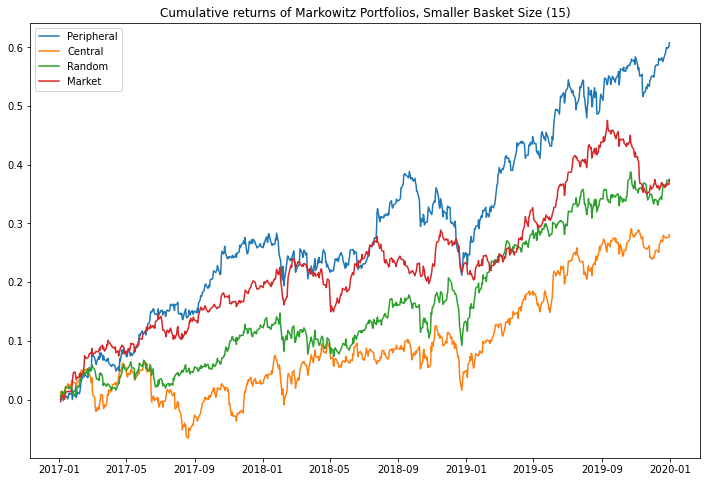

In [18]:
basket_size = 15

t_15 = Backtester(basket_size, 63, 1, 252, XY_rankings)
back_15 = t_15.backtest_markowitz_weight(log_returns_df, verbose=False)
print('\n---------------------------------\n')
print('Mean returns')
print(back_15.mean()*252)
print('\nStd:')
print(back_15.std() * np.sqrt(252))
print('\nRisk-adjusted return:')
print(back_15.mean()/eqw_back_results.std() * np.sqrt(252))
print('\nBetas:')
print(compute_betas(back_15, SnP_returns))

plt.figure(figsize=(12,8))
plt.title('Cumulative returns of Markowitz Portfolios, Smaller Basket Size (%d)'%basket_size)

portfolio_names = ['Peripheral', 'Central', 'Random', 'Market']
for name in portfolio_names:
    plt.plot(back_15[name].cumsum(), label=name)

plt.legend()
plt.show();

## Results and Findings
- Peripheral has high XS return
- central have significantly low XS return (often negative)
- Peripheral have relatively higher vol and TE than others (just a bit); no significant benefit (or dis-benefit) of diversification for one portfolio over another
- basket "turnover" quite high for both cen and per! 15-20 stocks come and go from each basket every quarter.
- betas for minvar ports are low -- but this is expected because we are trying to minimize var anyway!

It is interesting that the network can identify high-return stocks while only being fed correlation info.
- should we check if individual stocks in peripheral has higher idio risk but was diversified away so as to have portfolio vols/TEs inline with other portfolios?

Results that disgree Pozzi:
- No diversification benefit of portfolio from cen/per analysis. The "better" IR stems from periph's superior mean returns
    - (we dont even get consistently better actual IRs; the adj ret was defo better though)
- basket turnover. Our basket turnover is really high. (we arent even considering the holdings turnover!) 
    - Pozzi got low turnover probably because they averaged their EWMA correlation matrix over a rolling window.

# What to do now
Run the portfolio generators on different specifications of rolling window/basket sizes .etc; aggregate them and put them in tables (LaTeX and python notebook) then analyze and report.

Save some plots for prez and report.

What stats to show in table? Want to be concise and not too clutterd

TE or std? Show Adj ret or IR, or at all? Beta? 
- Gotta make sure these numbers are not "too bad"

In [19]:
#basket_freqs    = [63]
#rebalance_freqs = [1]
basket_sizes    = [5, 10, 20, 30, 60]
rolling_windows = [63, 126, 252]

add_cols = ['portfolio_type', 'basket_size', 'rolling_window', 'data_type']
results_table = pd.DataFrame(columns = portfolio_names + add_cols,).set_index(add_cols)

print('basket | rolling | MKW time | EQW time')
print('----------------------------------------')
for basket_size, rolling_window in product(basket_sizes, rolling_windows):
    #print('Processing: basket size ', basket_size, ', rolling window ', rolling_window)
    
    timestamp = time()
    backtester = Backtester(basket_size, 63, 1, rolling_window, XY_rankings)
    mkw_back_results = backtester.backtest_markowitz_weight(log_returns_df, verbose=False)
    results_table.loc[('mkw', basket_size, rolling_window, 'return'), :] = mkw_back_results.mean()*252
    results_table.loc[('mkw', basket_size, rolling_window, 'std'), :] = mkw_back_results.std() * np.sqrt(252)
    results_table.loc[('mkw', basket_size, rolling_window, 'r/s'), :] = mkw_back_results.mean()/mkw_back_results.std() * np.sqrt(252)
    mkwtime = time() - timestamp
    
    timestamp = time()
    eqw_back_results = backtester.backtest_equal_weight(log_returns_df, verbose=False)
    results_table.loc[('eqw', basket_size, rolling_window, 'return'), :] = eqw_back_results.mean()*252
    results_table.loc[('eqw', basket_size, rolling_window, 'std'), :] = eqw_back_results.std() * np.sqrt(252)
    results_table.loc[('eqw', basket_size, rolling_window, 'r/s'), :] = eqw_back_results.mean()/eqw_back_results.std() * np.sqrt(252)
    eqwtime = time() - timestamp
    
    print('%-6d | %-7d | %-5.3fs | %-5.3fs'%(basket_size, rolling_window, mkwtime, eqwtime))

results_table.columns.name = 'port type'
results_table.head()

basket | rolling | MKW time | EQW time
5      | 63      | 15.889s | 2.728s
5      | 126     | 15.014s | 2.422s
5      | 252     | 12.992s | 2.100s
10     | 63      | 15.576s | 2.677s
10     | 126     | 14.593s | 2.484s
10     | 252     | 13.581s | 2.245s
20     | 63      | 16.907s | 2.790s
20     | 126     | 16.166s | 2.679s
20     | 252     | 14.304s | 2.379s
30     | 63      | 17.411s | 2.934s
30     | 126     | 16.387s | 2.507s
30     | 252     | 13.624s | 2.226s
60     | 63      | 16.527s | 2.926s
60     | 126     | 16.481s | 2.705s
60     | 252     | 14.705s | 2.235s


Peripheral     Central  \
portfolio_type basket_size rolling_window data_type                          
mkw            5           63             return      0.139279 -0.00474167   
                                          std         0.178178    0.179763   
                                          r/s         0.781681  -0.0263774   
eqw            5           63             return      0.228569   0.0784241   
                                          std         0.243444    0.241028   

                                                        Random     Market  
portfolio_type basket_size rolling_window data_type                        
mkw            5           63             return     0.0823369   0.149833  
                                          std         0.151226  0.0838296  
                                          r/s         0.544464    1.78735  
eqw            5           63             return      0.117183   0.173884  
                                          std          0.16163   0.125607

In [50]:
results_table.loc['mkw'].stack().unstack(level=-2).unstack(-1)

data_type                      return                                   \
port type                  Peripheral     Central     Random    Market   
basket_size rolling_window                                               
5           63               0.139279 -0.00474167  0.0823369  0.149833   
            126              0.147006   -0.056744   0.111005  0.155114   
            252              0.124317  -0.0552707   0.182973  0.124782   
10          63               0.182389    0.133077    0.22442  0.149833   
            126              0.172892   0.0494209  0.0573932  0.155114   
            252              0.196333   0.0509673   0.134918  0.124782   
20          63               0.186943    0.147241   0.132659  0.149833   
            126              0.193035   0.0872525   0.156594  0.155114   
            252              0.170587   0.0627837   0.108176  0.124782   
30          63               0.183824    0.126553    0.17243  0.149833   
            126              0.167627    0.100554    0.09937  0.155114   
            252               0.14769   0.0870576  0.0802236  0.124782   
60          63               0.188425  -0.0964385  -0.411693  0.149833   
            126              0.206925    0.143174   0.151213  0.155114   
            252              0.111738    0.071248   0.125187  0.124782   

data_type                         std                                 \
port type                  Peripheral   Central    Random     Market   
basket_size rolling_window                                             
5           63               0.178178  0.179763  0.151226  0.0838296   
            126              0.176058  0.186928  0.140309  0.0872602   
            252              0.174068  0.187866  0.128551  0.0961551   
10          63               0.151378  0.138808   0.14054  0.0838296   
            126              0.147867  0.138056  0.128838  0.0872602   
            252              0.149243  0.135474  0.131396  0.0961551   
20          63               0.139037  0.123768   0.12691  0.0838296   
            126              0.128738   0.11686  0.113301  0.0872602   
            252               0.12841   0.11062  0.115517  0.0961551   
30          63               0.146841   0.12761  0.136206  0.0838296   
            126              0.123562  0.109067  0.119765  0.0872602   
            252              0.117794  0.101698  0.109168  0.0961551   
60          63               0.412648  0.391802  0.402685  0.0838296   
            126              0.132463  0.121143  0.124918  0.0872602   
            252              0.112135   0.10276  0.106871  0.0961551   

data_type                         r/s                                
port type                  Peripheral    Central    Random   Market  
basket_size rolling_window                                           
5           63               0.781681 -0.0263774  0.544464  1.78735  
            126              0.834985   -0.30356  0.791142   1.7776  
            252              0.714185  -0.294203   1.42335  1.29772  
10          63                1.20486   0.958716   1.59684  1.78735  
            126               1.16924   0.357977  0.445466   1.7776  
            252               1.31553   0.376215    1.0268  1.29772  
20          63                1.34456    1.18965    1.0453  1.78735  
            126               1.49944   0.746642    1.3821   1.7776  
            252               1.32846    0.56756  0.936449  1.29772  
30          63                1.25186   0.991723   1.26595  1.78735  
            126               1.35663   0.921946  0.829708   1.7776  
            252                1.2538   0.856037  0.734863  1.29772  
60          63               0.456625  -0.246141  -1.02237  1.78735  
            126               1.56214    1.18186   1.21049   1.7776  
            252              0.996464   0.693345   1.17139  1.29772

In [25]:
results_table.loc['eqw'].stack().unstack(level=-2).unstack(-1)

data_type                      return                                 \
port type                  Peripheral    Central    Random    Market   
basket_size rolling_window                                             
5           63               0.228569  0.0784241  0.117183  0.173884   
            126              0.247905   0.039967  0.210806  0.175185   
            252              0.185983  0.0252548  0.221459   0.16422   
10          63                0.19578   0.131603  0.217456  0.173884   
            126              0.210288    0.10077  0.176401  0.175185   
            252              0.167425  0.0977265  0.213017   0.16422   
20          63               0.207944   0.151588  0.185344  0.173884   
            126              0.217357   0.138549  0.178712  0.175185   
            252              0.186917   0.118391  0.167428   0.16422   
30          63               0.198906   0.160453  0.192578  0.173884   
            126              0.209439    0.15059  0.204552  0.175185   
            252              0.176147   0.143488  0.192339   0.16422   
60          63               0.184195   0.158519   0.16651  0.173884   
            126               0.19507   0.146947  0.196981  0.175185   
            252              0.160833   0.144451  0.160856   0.16422   

data_type                         std                                \
port type                  Peripheral   Central    Random    Market   
basket_size rolling_window                                            
5           63               0.243444  0.241028   0.16163  0.125607   
            126              0.235317   0.24557  0.151477  0.123064   
            252              0.243352  0.253219  0.158693  0.125923   
10          63               0.192065  0.172389  0.154208  0.125607   
            126              0.185237  0.174564  0.137783  0.123064   
            252              0.191265  0.177119   0.14043  0.125923   
20          63               0.170294  0.138397  0.139469  0.125607   
            126              0.164628  0.137106  0.130765  0.123064   
            252              0.169027  0.135564  0.140236  0.125923   
30          63               0.164426  0.121051  0.138056  0.125607   
            126              0.158538  0.120615  0.128785  0.123064   
            252              0.162701  0.120085  0.127043  0.125923   
60          63               0.156167  0.112783   0.12589  0.125607   
            126              0.151535  0.112012  0.127197  0.123064   
            252              0.156282  0.112801  0.130417  0.125923   

data_type                         r/s                                
port type                  Peripheral    Central    Random   Market  
basket_size rolling_window                                           
5           63               0.938898   0.325374  0.725007  1.38435  
            126                1.0535   0.162752   1.39167  1.42353  
            252              0.764257  0.0997351   1.39552  1.30413  
10          63                1.01934   0.763405   1.41015  1.38435  
            126               1.13524    0.57727   1.28028  1.42353  
            252              0.875358   0.551756   1.51689  1.30413  
20          63                1.22109    1.09531   1.32892  1.38435  
            126               1.32029    1.01052   1.36666  1.42353  
            252               1.10585   0.873319   1.19391  1.30413  
30          63                 1.2097    1.32549   1.39493  1.38435  
            126               1.32107    1.24852   1.58832  1.42353  
            252               1.08264    1.19489   1.51397  1.30413  
60          63                1.17948    1.40552   1.32265  1.38435  
            126               1.28729    1.31189   1.54863  1.42353  
            252               1.02912    1.28058    1.2334  1.30413

In [81]:
results_table.loc['mkw'].stack().unstack(level=-2).unstack(-1).loc[10:30].astype(float).round(decimals=2)

data_type                      return                              std  \
port type                  Peripheral Central Random Market Peripheral   
basket_size rolling_window                                               
10          63                   0.18    0.13   0.22   0.15       0.15   
            126                  0.17    0.05   0.06   0.16       0.15   
            252                  0.20    0.05   0.13   0.12       0.15   
20          63                   0.19    0.15   0.13   0.15       0.14   
            126                  0.19    0.09   0.16   0.16       0.13   
            252                  0.17    0.06   0.11   0.12       0.13   
30          63                   0.18    0.13   0.17   0.15       0.15   
            126                  0.17    0.10   0.10   0.16       0.12   
            252                  0.15    0.09   0.08   0.12       0.12   

data_type                                               r/s                 \
port type                  Central Random Market Peripheral Central Random   
basket_size rolling_window                                                   
10          63                0.14   0.14   0.08       1.20    0.96   1.60   
            126               0.14   0.13   0.09       1.17    0.36   0.45   
            252               0.14   0.13   0.10       1.32    0.38   1.03   
20          63                0.12   0.13   0.08       1.34    1.19   1.05   
            126               0.12   0.11   0.09       1.50    0.75   1.38   
            252               0.11   0.12   0.10       1.33    0.57   0.94   
30          63                0.13   0.14   0.08       1.25    0.99   1.27   
            126               0.11   0.12   0.09       1.36    0.92   0.83   
            252               0.10   0.11   0.10       1.25    0.86   0.73   

data_type                          
port type                  Market  
basket_size rolling_window         
10          63               1.79  
            126              1.78  
            252              1.30  
20          63               1.79  
            126              1.78  
            252              1.30  
30          63               1.79  
            126              1.78  
            252              1.30

In [82]:
print(results_table.loc['mkw'].stack().unstack(level=-2).unstack(-1).loc[10:30].astype(float).round(decimals=2).to_latex())

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
   & data\_type & \multicolumn{4}{l}{return} & \multicolumn{4}{l}{std} & \multicolumn{4}{l}{r/s} \\
   & port type & Peripheral & Central & Random & Market & Peripheral & Central & Random & Market & Peripheral & Central & Random & Market \\
basket\_size & rolling\_window &            &         &        &        &            &         &        &        &            &         &        &        \\
\midrule
10 & 63  &       0.18 &    0.13 &   0.22 &   0.15 &       0.15 &    0.14 &   0.14 &   0.08 &       1.20 &    0.96 &   1.60 &   1.79 \\
   & 126 &       0.17 &    0.05 &   0.06 &   0.16 &       0.15 &    0.14 &   0.13 &   0.09 &       1.17 &    0.36 &   0.45 &   1.78 \\
   & 252 &       0.20 &    0.05 &   0.13 &   0.12 &       0.15 &    0.14 &   0.13 &   0.10 &       1.32 &    0.38 &   1.03 &   1.30 \\
20 & 63  &       0.19 &    0.15 &   0.13 &   0.15 &       0.14 &    0.12 &   0.13 &   0.08 &       1.34 &    1.19 &   1.05 &   1.79 \\
   & 126 &  

In [83]:
print(results_table.loc['eqw'].stack().unstack(level=-2).unstack(-1).loc[10:30].astype(float).round(decimals=2).to_latex())

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
   & data\_type & \multicolumn{4}{l}{return} & \multicolumn{4}{l}{std} & \multicolumn{4}{l}{r/s} \\
   & port type & Peripheral & Central & Random & Market & Peripheral & Central & Random & Market & Peripheral & Central & Random & Market \\
basket\_size & rolling\_window &            &         &        &        &            &         &        &        &            &         &        &        \\
\midrule
10 & 63  &       0.20 &    0.13 &   0.22 &   0.17 &       0.19 &    0.17 &   0.15 &   0.13 &       1.02 &    0.76 &   1.41 &   1.38 \\
   & 126 &       0.21 &    0.10 &   0.18 &   0.18 &       0.19 &    0.17 &   0.14 &   0.12 &       1.14 &    0.58 &   1.28 &   1.42 \\
   & 252 &       0.17 &    0.10 &   0.21 &   0.16 &       0.19 &    0.18 &   0.14 &   0.13 &       0.88 &    0.55 &   1.52 &   1.30 \\
20 & 63  &       0.21 &    0.15 &   0.19 &   0.17 &       0.17 &    0.14 &   0.14 &   0.13 &       1.22 &    1.10 &   1.33 &   1.38 \\
   & 126 &  

In [ ]:
#latex_table_output = results_table.loc['mkw'].to_latex()
#results_table.loc['mkw']
#pd.pivot_table(results_table.loc['mkw'], index=['data_type'], columns=['basket_size', 'rolling_window'])
#results_table.loc['mkw'].unstack()